In [1]:
# utils 
from utils import ML_, Preprocessing_, Postprocessing_, Visualize_

# math libraries
import numpy as np
from scipy.constants import g

# df libraries
import xarray as xr
import pandas as pd
import geopandas as gpd
import rioxarray

# visualization-projection libraries
import matplotlib.pyplot as plt
import cartopy
from shapely.geometry import mapping

# system libraries
import os
import glob

# warnings
import warnings
warnings.filterwarnings('ignore')

# autoload
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [37]:
class classifyRegions:
    """
    Class to classify the Turkey into regions with respect to atmospheric conditions
    """
    
    def __init__(self, ds_path, shp_path, start_year, end_year, crs, lon_name, lat_name):
        """
        Attributes:
            ds_path: str - path to open xr.Dataset
            shp_path: str - path to open gpd.file
            start_year: int - start year of data to be clipped
            end_year: int - end year of data to be clipped
            crs: cartopy.crs - projection information to xr.Dataset
            lon_name: str - name of longitude coordinate of xr.Dataset
            lat_name: str - name of latitude coordinate of xr.Dataset
        """
        self.ds_path    = ds_path
        self.shp_path   = shp_path
        self.start_year = start_year
        self.end_year   = end_year
        self.crs        = crs
        self.lon_name   = lon_name
        self.lat_name   = lat_name
        
    def open_xarray(self, *args, **kwargs):
        """
        Method to open xr.Dataset
        """
        
        ds = xr.open_dataset(self.ds_path, *args, **kwargs)
        ds.sel(time=slice(self.start_year, self.end_year))
        return ds
    
    def assign_proj_info(self, ds, *args, **kwargs):
        """
        Method to assign projection info to xr.Dataset
        
        Parameters:
            ds: xr.Dataset - xarray dataset
            
        Returns:
            xr.Dataset - xarray dataset with projection info assigned
        """
        
        return Preprocessing_.write_crs_info(ds, self.crs)  
    
    def time_mean(self, ds):
        """
        Method to take the mean over time dimension of xr.Dataset
        
        Parameters:
            ds: xr.Dataset - xarray dataset
            
        Returns:
            xr.Dataset - xarray dataset averaged over time dimension
        """
        
        return ds.mean(dim='time')              
    
    def interpolate_xy(self, ds, interp_size):
        """
        Method to interpolate the xr.Dataset over x-y dimensions
        
        Parameters:
            ds: xr.Dataset - xarray dataset
            
        Returns:
            xr.Dataset - xarray dataset interpolated over x-y dimension
        """
        
        return Preprocessing_.interpolate_xy(ds, self.lon_name, self.lat_name, interp_size)
    
    def clip_area(self, ds):
        """
        Method to clip the xr.Dataset into shapefile area
        
        Parameters:
            ds: xr.Dataset - xarray dataset
            
        Returns:
            xr.Dataset - xarray dataset clipped into shapefile area
        """
        
        return Preprocessing_.clip_area(ds, self.shp_path, self.lon_name, self.lat_name)
    
    def xr_to_pd(self, ds, with_na=False):
        """
        Method to turn xarray dataset into pandas DataFrame
        
        Parameters:
            ds: xr.Dataset - xarray dataset
            with_na: bool - decides on if return pd.DataFrame with nans or not
            
        Returns:
            pd.DataFrame - pandas dataframe of corresponding xr.Dataset
        """
        
        return Preprocessing_.xr_to_pd(ds, self.lon_name, self.lat_name, with_na)
    
    def get_var_names(self, df):
        """
        Method to get the list of variable names from pd.DataFrame
        
        Parameters:
            df: pd.DataFrame - pandas dataframe
        
        Returns:
            list - list of variable names
        """
        
        return [col for col in df.columns if col not in [self.lat_name, self.lon_name, 'lat_lon']]
    
    def standardize(self, df):
        """
        Method to standardize the pd.DataFrame
        
        Parameters:
            df: pd.DataFrame - pandas dataframe
        
        Returns:
            np.array - numpy array of standardized pd.DataFrame
        """
        
        return ML_.standardize(df)
    
    def Algo_KMeans(self, X, n_clusters, *args, **kwargs):
        """
        Method to fit KMeans algorithm to data
        
        Parameters:
            X: np.array - training data
            n_clusters: int - the cluster number for KMeans algorithm
            
        Returns:
            sklearn.KMeans model - fitted KMeans model 
        """
        
        return ML_.Algo_KMeans(X, n_clusters, *args, **kwargs)
    
    def cluster_number_KMeans(self, X, max_cluster, *args, **kwargs):
        """
        Method to find the optimum cluster number for KMeans algorithm using Elbow method

        Parameters:
            X: np.array - training data
            max_cluster: int - maximum cluster number to check 

        Returns:
            list - KMeans inertia wrt n_clusters from Elbow method
        """
    
        sum_of_squared_distances, K = ML_.cluster_number_KMeans(X, max_cluster)
        return sum_of_squared_distances, K
    
    def Algo_DBScan(self, X, epsilon, min_samples, *args, **kwargs):
        """
        Method to fit DBScan algorithm to data
        
        Parameters:
            X: np.array - training data
            epsilon: float - epsilon value for DBScan algorithm
            min_samples: float - min_samples value for DBScan algorithm
            
        Returns:
            sklearn.DBScan model - fitted DBScan model
        """
        
        return ML_.Algo_DBScan(X, epsilon, min_samples, *args, **kwargs)
    
    def predict(self, fit, X):
        """
        Method to predict outcomes using trained model
        
        Parameters:
            fit: sklearn model - trained model
            X: training data
            
        Returns:
            np.array - prediction results in numpy array
        """
        return ML_.predict(fit, X)
    
    def pred_to_df(self, y_pred, df):
        """
        Method to turn prediction(np.array) into pd.DataFrame
        
        Parameters:
            y_pred: np.array - prediction results in numpy array
            df: pd.DataFrame - pandas dataframe prediction results will be merged to
            
        Returns:
            pd.DataFrame - pandas dataframe including prediction results
        """
        
        return ML_.pred_to_df(y_pred, df)
    
    def pd_to_xr(self, df_with_na, df_pred):
        """
        Method to turn pd.DataFrame back into xr.Dataset
        
        Parameters:
            df_with_na: pd.DataFrame - base dataframe to be turned into xr.Dataset (with_na included)
            df_pred: pandas dataframe including prediction results (will be merged into with_na pd.DataFrame)
            
        Returns:
            xr.Dataset - xarray dataset with prediction information
        """
        return Postprocessing_.pd_to_xr(df_with_na, df_pred, self.lon_name, self.lat_name)

## 1. General Parameters

In [38]:
# paths
ds_feature  = 'Single'
ds_path     = glob.glob(f'Dataset/*{ds_feature}*')[0]
shp_prov    = glob.glob('Shapefiles/*provinces.shp*')[0]

# coordinate parameters
start_year  = '1981'
end_year    = '2010'
lon_name    = 'longitude'
lat_name    = 'latitude'

# projection parameters
globe       = cartopy.crs.Globe()
crs         = cartopy.crs.PlateCarree(globe=globe)

# interpolation parameters
interp_size = 8

### 2. Define Dataset for use in ML

In [39]:
# initiate instance
classification = classifyRegions(ds_path, shp_prov,
                                 start_year, end_year,
                                 crs, lon_name, lat_name)

# open xr.Dataset
ds         = classification.open_xarray()
# assign projection to xr.Dataset
ds         = classification.assign_proj_info(ds)
# average over time
ds_mean    = classification.time_mean(ds)
# interpolate the xr.Dataset
interp_ds  = classification.interpolate_xy(ds_mean, interp_size)
# clip xr.Dataset on given area
clip_ds    = classification.clip_area(interp_ds)
# convert xr.Dataset into pd.DataFrame with nans dropped
df         = classification.xr_to_pd(clip_ds, with_na=False)
# convert xr.Dataset into pd.DataFrame with nans remain
df_with_na = classification.xr_to_pd(clip_ds, with_na=True)


# get only variable names from pd.DataFrame
variables  = classification.get_var_names(df)
#variables  = ['tp']

# define X with only meteorological variables
X          = df[variables]
# standardize meteorological data
X_trans    = classification.standardize(X)

In [40]:
X_trans

array([[-1.74437965, -1.14649938,  1.02483674,  0.27603689,  1.15737901,
        -0.08525308],
       [-1.81122073, -1.14074364,  1.02448617,  0.25506533,  1.16605679,
        -0.09087979],
       [-1.77911946, -1.12066742,  1.02412614,  0.23740701,  1.17461044,
        -0.0523145 ],
       ...,
       [ 1.99441694,  1.75796837,  2.2282862 ,  1.65583281, -1.59995039,
        -0.17990036],
       [ 2.10476385,  1.68339314,  2.1836955 ,  1.64702703, -1.60020078,
        -0.26743918],
       [ 2.35399585,  1.55447087,  2.06916118,  1.65873501, -1.6250991 ,
        -0.47420119]])

In [41]:
np.shape(X_trans)

(87092, 6)

### 3. K-Means Model

In [47]:
inertia_list, K = classification.cluster_number_KMeans(X_trans, 15)

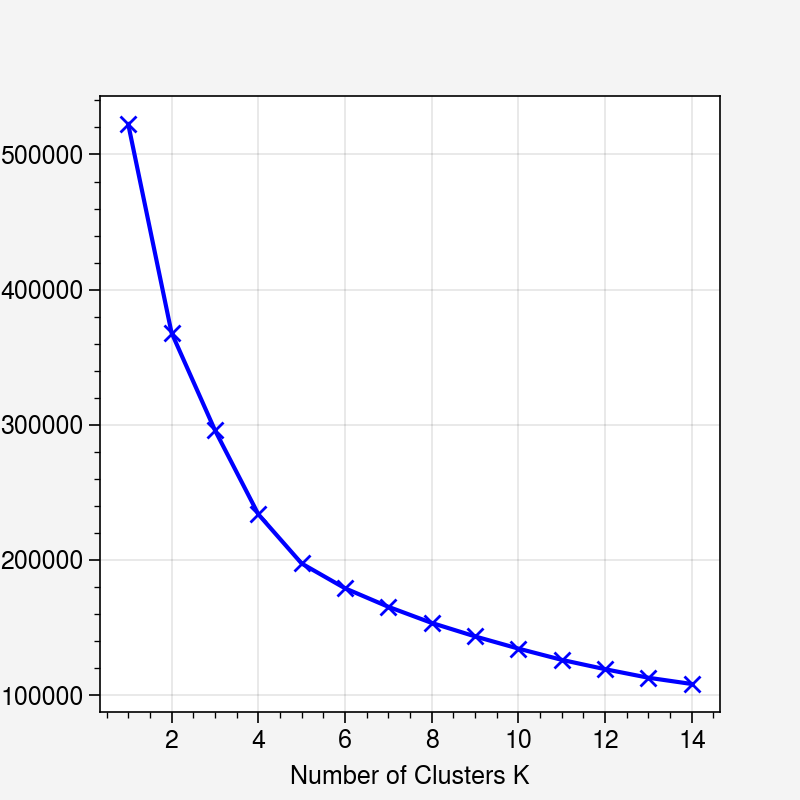

In [48]:
plt.plot(K, inertia_list, 'bx-')
plt.xlabel('Number of Clusters K')
plt.ylabel('Sum of squared distances')
plt.show()

Elbow method shows that around 14-15 is the best limit to KMeans n_clusters. This gives detailed information about the regional climate classification of Turkey. But we know that coarsely Turkey has around 6 different climate pattern. Let's show both in a map:

#### 3.1 Plot

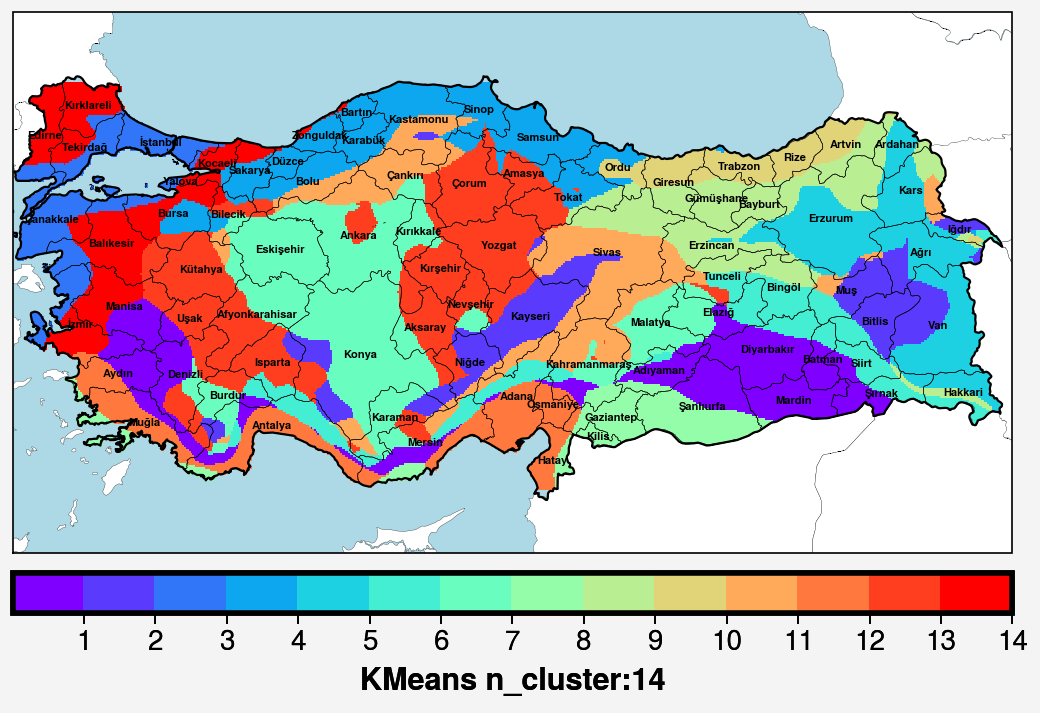

In [51]:
# ML Parameters
n_clusters = 14

# define model
fit        = classification.Algo_KMeans(X_trans, n_clusters, random_state=0)
y_pred     = classification.predict(fit, X_trans)

# convert prediction pd.DataFrame to xr.Dataset
df_pred    = classification.pred_to_df(y_pred, df)
ds_pred    = classification.pd_to_xr(df_with_na, df_pred)
ds_pred    = classification.assign_proj_info(ds_pred)

# cmap, vmin, vmax, ticks
cmap=plt.get_cmap('rainbow')
cbar_name = f'KMeans n_cluster:{n_clusters}'
vmin=0
vmax=n_clusters
ticks = np.arange(1,n_clusters+1)

# variable
variable = 'pred'
Visualize_.plot_whole(ds_pred, cmap,
                      vmin, vmax,
                      ticks, variable,
                      crs, shp_prov,
                      lon_name, lat_name,
                      cbar_name)

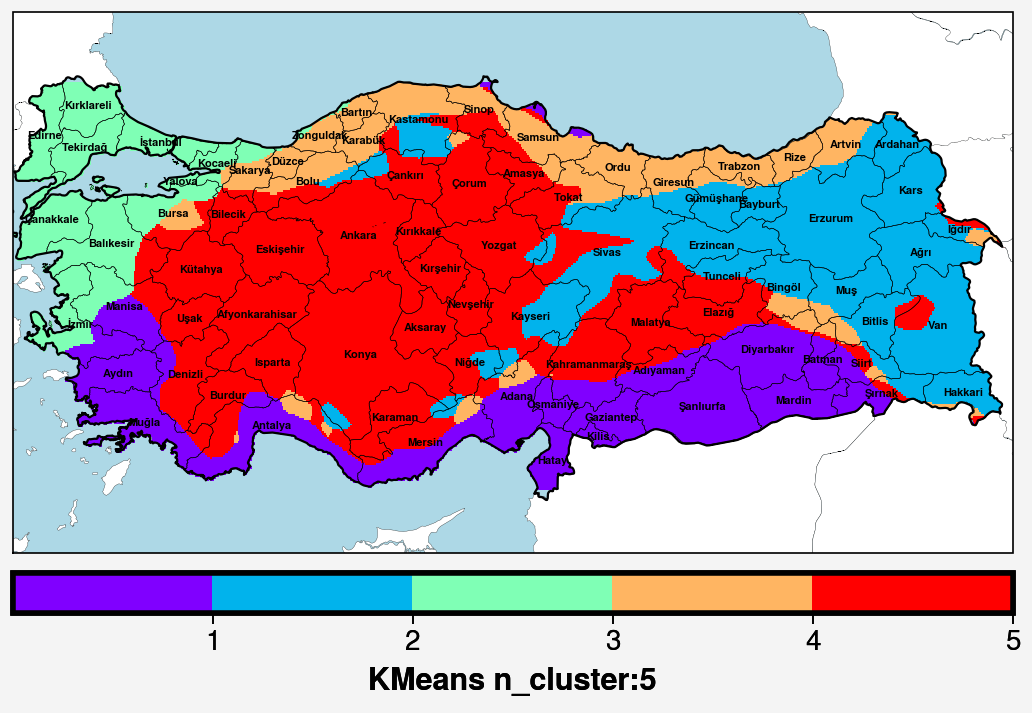

In [61]:
# ML Parameters
n_clusters = 5

# define model
fit        = classification.Algo_KMeans(X_trans, n_clusters, random_state=0)
y_pred     = classification.predict(fit, X_trans)

# convert prediction pd.DataFrame to xr.Dataset
df_pred    = classification.pred_to_df(y_pred, df)
ds_pred    = classification.pd_to_xr(df_with_na, df_pred)
ds_pred    = classification.assign_proj_info(ds_pred)

# cmap, vmin, vmax, ticks
cmap=plt.get_cmap('rainbow')
cbar_name = f'KMeans n_cluster:{n_clusters}'
vmin=0
vmax=n_clusters
ticks = np.arange(1,n_clusters+1)

# variable
variable = 'pred'
Visualize_.plot_whole(ds_pred, cmap,
                      vmin, vmax,
                      ticks, variable,
                      crs, shp_prov,
                      lon_name, lat_name,
                      cbar_name)

Sometimes, we do not need to know every detail about the classification of the climate but, a coarse clustering is also can be very informative.

### 2. Birch Model

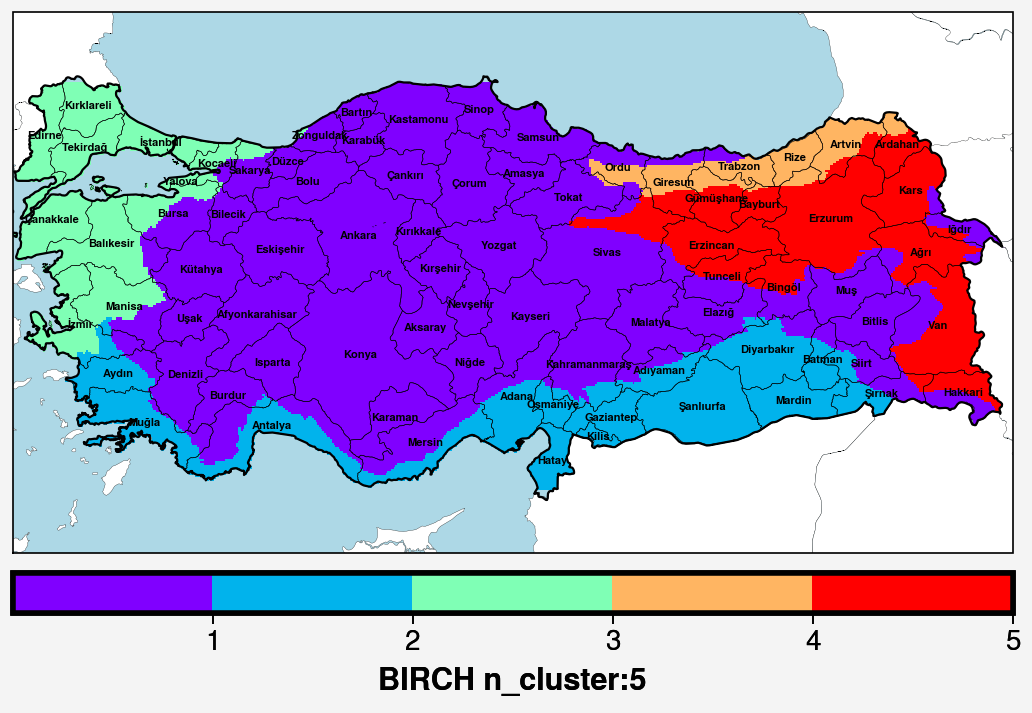

In [66]:
from sklearn.cluster import Birch

# define the model
n_clusters = 5
model = Birch(threshold=0.1, n_clusters=n_clusters)
# fit the model
model.fit(X_trans)
# assign a cluster to each example
y_pred = model.predict(X_trans)

# convert prediction pd.DataFrame to xr.Dataset
df_pred    = classification.pred_to_df(y_pred, df)
ds_pred    = classification.pd_to_xr(df_with_na, df_pred)
ds_pred    = classification.assign_proj_info(ds_pred)

# cmap, vmin, vmax, ticks
cmap=plt.get_cmap('rainbow')
cbar_name = f'BIRCH n_cluster:{n_clusters}'
vmin=0
vmax=n_clusters
ticks = np.arange(1,n_clusters+1)

# variable
variable = 'pred'
Visualize_.plot_whole(ds_pred, cmap,
                      vmin, vmax,
                      ticks, variable,
                      crs, shp_prov,
                      lon_name, lat_name,
                      cbar_name)

Using only 5 n_clusters, KMeans algorithm made better prediction compared to BIRCH algorithm.

### 3. Mini-Batch KMeans Model

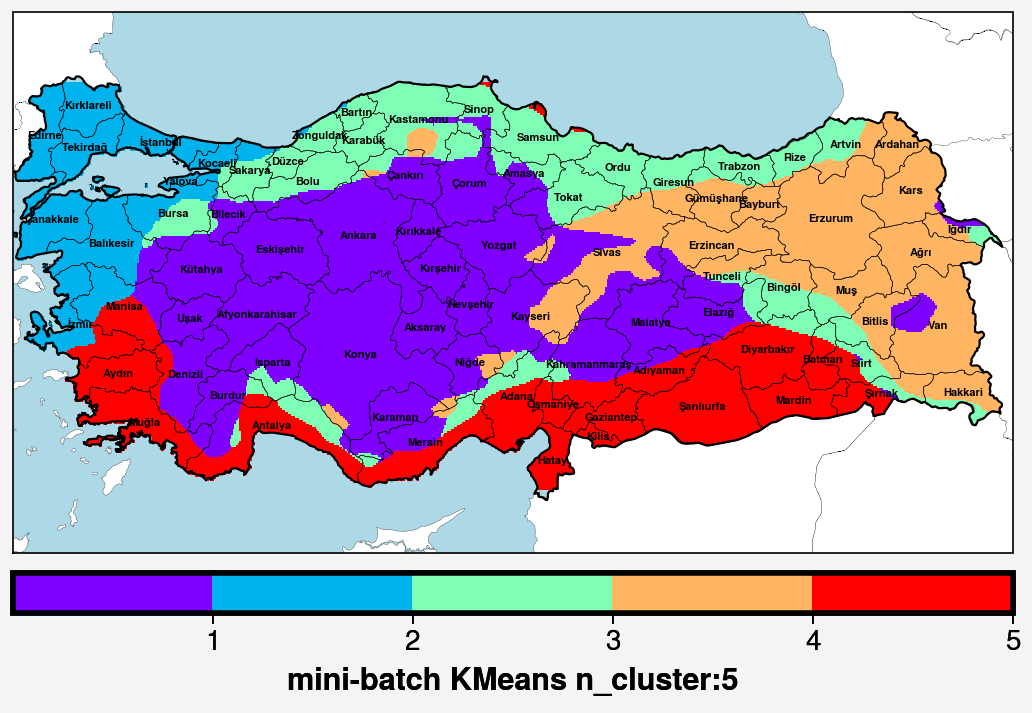

In [67]:
from sklearn.cluster import MiniBatchKMeans

# define the model
n_clusters = 5

model = MiniBatchKMeans(n_clusters=n_clusters)
# fit the model
model.fit(X_trans)
# assign a cluster to each example
y_pred= model.predict(X_trans)

# convert prediction pd.DataFrame to xr.Dataset
df_pred    = classification.pred_to_df(y_pred, df)
ds_pred    = classification.pd_to_xr(df_with_na, df_pred)
ds_pred    = classification.assign_proj_info(ds_pred)

# cmap, vmin, vmax, ticks
cmap=plt.get_cmap('rainbow')
cbar_name = f'mini-batch KMeans n_cluster:{n_clusters}'
vmin=0
vmax=n_clusters
ticks = np.arange(1,n_clusters+1)

# variable
variable = 'pred'
Visualize_.plot_whole(ds_pred, cmap,
                      vmin, vmax,
                      ticks, variable,
                      crs, shp_prov,
                      lon_name, lat_name,
                      cbar_name)

In [68]:
# For comparison purposes:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://www.researchgate.net/profile/Ali-Koc-6/publication/273290977/figure/fig1/AS:391988416401416@1470468729551/Climate-zones-of-Turkey-in-reverse-gearcom-Turkey-climate-mapgif.png")